In [12]:
# DataFrame
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from tqdm import tqdm_notebook, tnrange

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM,Input
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping , CSVLogger
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import LSTM, Dense, Embedding, Bidirectional,GlobalMaxPool1D, Lambda
from keras.layers import TimeDistributed
from keras.layers import *
from keras.optimizers import Adam,Nadam

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

#spacy
import wordninja
from nltk.tokenize import TweetTokenizer
stop_words = set(stopwords.words('english'))
tknzr = TweetTokenizer()
# import spaCy's language model
import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
tokenizer = nlp.Defaults.create_tokenizer(nlp)


from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging

/Users/subir/pythonenv/default/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until
Using TensorFlow backend.


In [13]:
# from simpletransformers.classification import ClassificationModel
# import pandas as pd
# import logging


# logging.basicConfig(level=logging.INFO)
# transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

# # Train and Evaluation data needs to be in a Pandas Dataframe of two columns. 
# #The first column is the text with type str, and the second column is the label with type int.
# train_data = [['Example sentence belonging to class 1', 1], ['Example sentence belonging to class 0', 0]]
# train_df = pd.DataFrame(train_data)

# eval_data = [['Example eval sentence belonging to class 1', 1], ['Example eval sentence belonging to class 0', 0]]
# eval_df = pd.DataFrame(eval_data)

# # Create a ClassificationModel
# model = ClassificationModel('roberta', 'roberta-base',use_cuda=False) # You can set class weights by using the optional weight argument

# # Train the model
# model.train_model(train_df)

# # Evaluate the model
# result, model_outputs, wrong_predictions = model.eval_model(eval_df)

In [4]:
train_df

,0,1
0,Example sentence belonging to class 1,1
1,Example sentence belonging to class 0,0


In [14]:
train=pd.read_csv('./data/train_E6oV3lV.csv')
test=pd.read_csv('./data/test_tweets_anuFYb8.csv')

In [15]:
train.head()
train=train.sample(frac=1)

In [16]:
train.label.value_counts()

0    29720
1    2242 
Name: label, dtype: int64

In [17]:
combi = train.append(test, ignore_index=True,sort=False)

In [18]:
# remove special characters, numbers, punctuations
import contractions
combi['tidy_tweet'] = combi['tweet'].apply(
    lambda x: [contractions.fix(word) for word in x.split()])

combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join(x))
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("@user", "")
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z0-9#]", " ")
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace('#', 'hashtag ')


In [19]:
combi.head()

,id,label,tweet,tidy_tweet
0,27559,0.0,@user @user scheduled delivery is now 23 hrs late. no phone call or update in the last 19 hrs. you have my $$ and purchase.,scheduled delivery is now 23 hrs late no phone call or update in the last 19 hrs you have my and purchase
1,18415,0.0,"got a facial peel this week to deal with my sun damage. i'm at the ""cabbage patch doll with a burned face"" stage. progressing to snake",got a facial peel this week to deal with my sun damage I am at the cabbage patch doll with a burned face stage progressing to snake
2,3144,0.0,my favorite place to be in the summer...love you chicago!! ð #happiness #chitownâ¦,my favorite place to be in the summer love you chicago hashtag happiness hashtag chitown
3,9939,0.0,i am thankful for mountains. #thankful #positive,i am thankful for mountains hashtag thankful hashtag positive
4,16391,0.0,have you been when feeling #hungry? science says this is normal #hangry,have you been when feeling hashtag hungry science says this is normal hashtag hangry


In [20]:
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x: tknzr.tokenize(x))
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x: [word for word in x if word not in stop_words])

In [21]:

combi.tidy_tweet = combi.tidy_tweet.apply(lambda x: [wordninja.split(word) for word in x if word not in 'hashtag'])

In [22]:
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x:[item for sublist in x for item in sublist] )

In [23]:
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x:' '.join(x))

In [24]:
combi.head(10)

,id,label,tweet,tidy_tweet
0,27559,0.0,@user @user scheduled delivery is now 23 hrs late. no phone call or update in the last 19 hrs. you have my $$ and purchase.,scheduled delivery 23 hrs late phone call update last 19 hrs purchase
1,18415,0.0,"got a facial peel this week to deal with my sun damage. i'm at the ""cabbage patch doll with a burned face"" stage. progressing to snake",got facial peel week deal sun damage I cabbage patch doll burned face stage progressing snake
2,3144,0.0,my favorite place to be in the summer...love you chicago!! ð #happiness #chitownâ¦,favorite place summer love chicago happiness chi town
3,9939,0.0,i am thankful for mountains. #thankful #positive,thankful mountains thankful positive
4,16391,0.0,have you been when feeling #hungry? science says this is normal #hangry,feeling hungry science says normal h angry
5,12483,0.0,"""praise the poet"" #sundayfunday #aist #digitala #rain #rainbow #a #words #design #prayers #om #namaste",praise poet sunday fun day a is t digital a rain rainbow words design prayers om namaste
6,14072,0.0,"hello, i noticed that u are a health fan, so i ask u to check my free app, it's called mytraining on apple",hello noticed health fan ask check free app called my training apple
7,19943,0.0,@user got shot at her own conce. rip. i used to always watch her sing on youtube,got shot c once rip used always watch sing youtube
8,6134,0.0,@user i was able to do it! i had to reinstall the app on my #iphone6 and reconnect the #fitbit #surge to the app. very,able reinstall app iphone 6 reconnect fit bit surge app
9,15213,0.0,"so tonights job, resign to netflix ready for tomorrow! 1 more day. #oitnb #season4 ! #alexandpiper #onlyonemoregetup :-d",to nights job resign netflix ready tomorrow 1 day o it nb season 4 alex and piper only one more getup


/Users/subir/pythonenv/default/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


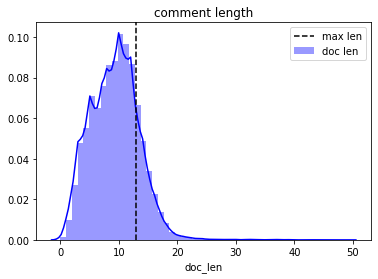

In [28]:
import seaborn as sns
combi['doc_len'] = combi['tidy_tweet'].apply(lambda words: len(words))
max_seq_len = np.round(combi['doc_len'].mean() + combi['doc_len'].std()).astype(int)
sns.distplot(combi['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [29]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join(x))

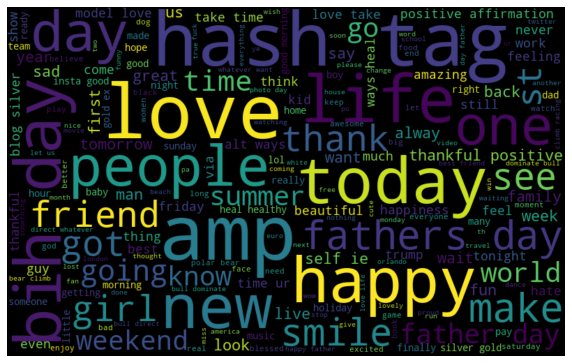

In [30]:
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

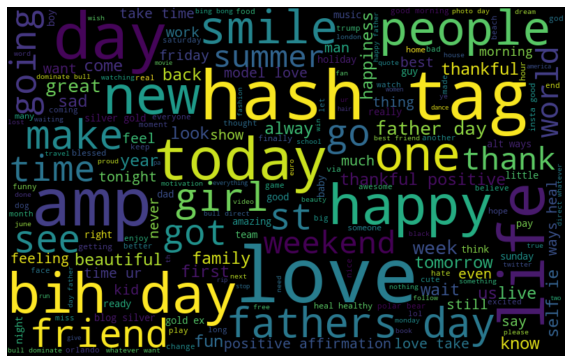

In [31]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

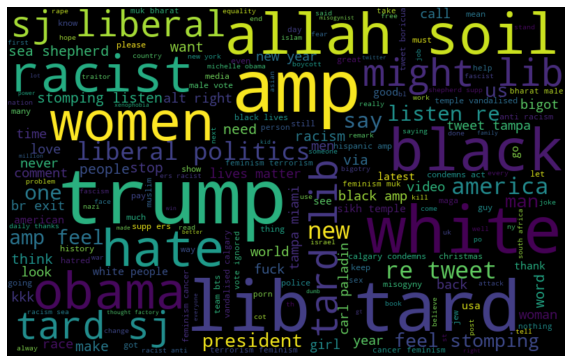

In [32]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [33]:
df_train=combi[:len(train)]
df_test=combi[len(train):]

In [34]:
df_test.drop('label',1,inplace=True)

/Users/subir/pythonenv/default/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
df_test.head()

,id,tweet,tidy_tweet,doc_len
31962,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦,studio life is life requires passion dedication willpower find new materials,11
31963,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why,white supremacists want everyone see new birds movie,8
31964,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!,safe ways heal acne alt ways to heal healthy healing,10
31965,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite",hp cursed child book reservations already yes harry potter potter more favorite,12
31966,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦",rd bih day amazing hilarious nephew eli ah mir uncle dave loves misses,13


In [36]:
df_train

,id,label,tweet,tidy_tweet,doc_len
0,27559,0.0,@user @user scheduled delivery is now 23 hrs late. no phone call or update in the last 19 hrs. you have my $$ and purchase.,scheduled delivery 23 hrs late phone call update last 19 hrs purchase,12
1,18415,0.0,"got a facial peel this week to deal with my sun damage. i'm at the ""cabbage patch doll with a burned face"" stage. progressing to snake",got facial peel week deal sun damage cabbage patch doll burned face stage progressing snake,15
2,3144,0.0,my favorite place to be in the summer...love you chicago!! ð #happiness #chitownâ¦,favorite place summer love chicago happiness chi town,8
3,9939,0.0,i am thankful for mountains. #thankful #positive,thankful mountains thankful positive,4
4,16391,0.0,have you been when feeling #hungry? science says this is normal #hangry,feeling hungry science says normal angry,6
...,...,...,...,...,...
31957,7245,0.0,happier and wrinkle free! :) what could be better? #botox #wrinklefreewednesday #westchester #nyc #medspa,happier wrinkle free could better botox wrinkle free wednesday westchester nyc med spa,13
31958,27814,0.0,#babies hudson baby minky blanket - pink giraffe #bouncingbaby,babies hudson baby inky blanket pink giraffe bouncing baby,9
31959,22704,0.0,@user @user thank you for your amazing #glutenfree options ð #grateful #peaceofmind @user,thank amazing gluten free options grateful peace of mind,9
31960,30838,0.0,@user my cats are one of the greatest things ever! they make me so happy. #depression #cats #anxiety #mentalhealth #meow,cats one greatest things ever make happy depression cats anxiety mental health meow,13


In [37]:
train_df = df_train[['tidy_tweet','label']]

In [40]:
train_df.columns =[0,1]
train_df.sample(frac=1)

,0,1
24805,ends,0.0
22679,salary wold make wondering salary make happy,0.0
25480,loving reaction one reasons love job much makeup bride bridal,0.0
29263,ww yeah good bing bong bing bong,0.0
26691,bih day cake made mom bih day mom fondant pumpkin chocolate delicious beautiful amazing,0.0
...,...,...
2574,hallelujah as jai veni aiv wen co ffe still black songs solomon david da in ly fathers day boy moses joshua 144 000,0.0
25208,bed yoga routine help sleep like baby wo has sleep,0.0
12876,want folks matter situation,0.0
29196,new gilmore girls new book fan girl ing still thing think thing,0.0


In [43]:
model = ClassificationModel('roberta', 'roberta-base',use_cuda=False) # You can set class weights by using the optional weight argument


In [ ]:
#train the model
model.train_model(train_df)

/Users/subir/pythonenv/default/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:251: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


Running loss: 0.405847

/Users/subir/pythonenv/default/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.516560

/Users/subir/pythonenv/default/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.463969

In [143]:
Submission = pd.DataFrame()
Submission['id']=df_test['id']
Submission['label']=sentiment

In [135]:
Submission.to_csv('Submission_BiLSTM_Fasttext.csv',index=False)